# Seed to alignment
This notebook will walk through how to make a seed dataset for use in a topiary ASR study as well as a one-step seed-to-alignment function where the user can manipulate parameters to suit their needs. We include definitions of the arguments used in the function and explanations for the chosen default parameters.

<a href="https://githubtocolab.com/harmslab/topiary-examples/blob/main/notebooks/01_seed_to_alignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Setup
Start by running the cells below to set up topiary and all required software.

In [ ]:
### THIS CELL SETS UP TOPIARY IN A GOOGLE COLAB ENVIRONMENT. 
### IF RUNNING THIS NOTEBOOK LOCALLY, IT MAY BE SAFELY DELETED.
### IF RUNNING LOCALLY, ACTIVATE THE TOPIARY ENVIRONMENT IN CONDA
### AND RE-OPEN THIS NOTEBOOK.

#@title Install software

#@markdown #### Installation requires two steps.

#@markdown 1. Install the software by pressing the _Play_ button on the left.
#@markdown Please be patient. This will take several minutes. <font color='teal'>
#@markdown After the  installation is complete, the kernel will reboot 
#@markdown and Colab will complain that the session crashed. This is normal.</font>
#@markdown <br/>
#@markdown 2. After this cell runs, run the "Initialize environment" cell that follows.

try:
    import google.colab
    RUNNING_IN_COLAB = True
except ImportError:
    RUNNING_IN_COLAB = False
except Exception as e: 
    err = "Could not figure out if runnning in a colab notebook\n"
    raise Exception(err) from e

if RUNNING_IN_COLAB:

    import os
    os.chdir("/content/")

    import urllib.request
    urllib.request.urlretrieve("https://raw.githubusercontent.com/harmslab/topiary-examples/main/notebooks/colab_installer.py",
                              "colab_installer.py")

    import colab_installer
    colab_installer.install_topiary(install_raxml=False,
                                    install_generax=False)

In [ ]:
import topiary
import numpy as np
import pandas as pd 

### EVERYTHING AFTER THIS LINE IS IS USED TO SET UP TOPIARY IN A GOOGLE
### COLAB ENVIRONMENT. IF RUNNING THIS NOTEBOOK LOCALLY, THE LINES BELOW
### IN THIS CELL MAY BE SAFELY DELETED. 

#@title Initialize environment

#@markdown  Run this cell to initialize the environment after installation.
#@markdown (This cell can also be run if the kernel dies during a calculation,
#@markdown allowing you to reload modules without having to
#@markdown reinstall). If your 

#@markdown We recommend setting up a working directory on your google drive. This is a 
#@markdown convenient way to pass files to topiary and will allow you to save
#@markdown your work. For example, if you type `topiary_work` into the form
#@markdown field below, topiary will save all of its calculations in the 
#@markdown `topiary_work` directory in MyDrive (i.e. the top directory at
#@markdown https://drive.google.com). This script will create the directory if 
#@markdown it does not already exist. If the directory already exists, any files
#@markdown that are already in that directory will be available to topiary. You could, 
#@markdown for example, put a file called `seed.csv` in `topiary_work` and then
#@markdown access it as "seed.csv" in all cells below.
#@markdown <br/><br/>
#@markdown Note: Google may prompt you for permission to access the drive. 
#@markdown To work in a temporary colab environment, leave this blank. 

# Select a working directory on google drive
google_drive_directory = "" #@param {type:"string"}

try:
    import google.colab
    RUNNING_IN_COLAB = True
except ImportError:
    RUNNING_IN_COLAB = False
except Exception as e: 
    err = "Could not figure out if runnning in a colab notebook\n"
    raise Exception(err) from e

if RUNNING_IN_COLAB:

    import os
    os.chdir("/content/")

    topiary._in_notebook = "colab"
    import colab_installer
    colab_installer.initialize_environment()
    colab_installer.mount_google_drive(google_drive_directory)

## Construct a seed dataset
The first step in a topiary ASR calculation is to construct a seed dataset. This can be done by making a pandas dataframe or in excel (or similar software). This dataset defines protein family members of interest and the distribution of these proteins across species. Topiary uses this seed dataset to automatically find and download sequences to put into the alignment and, ultimately, evolutionary tree. An example for the LY86/LY96 protein family, a pair of closely related innate immune proteins, is shown in **Table 1**.

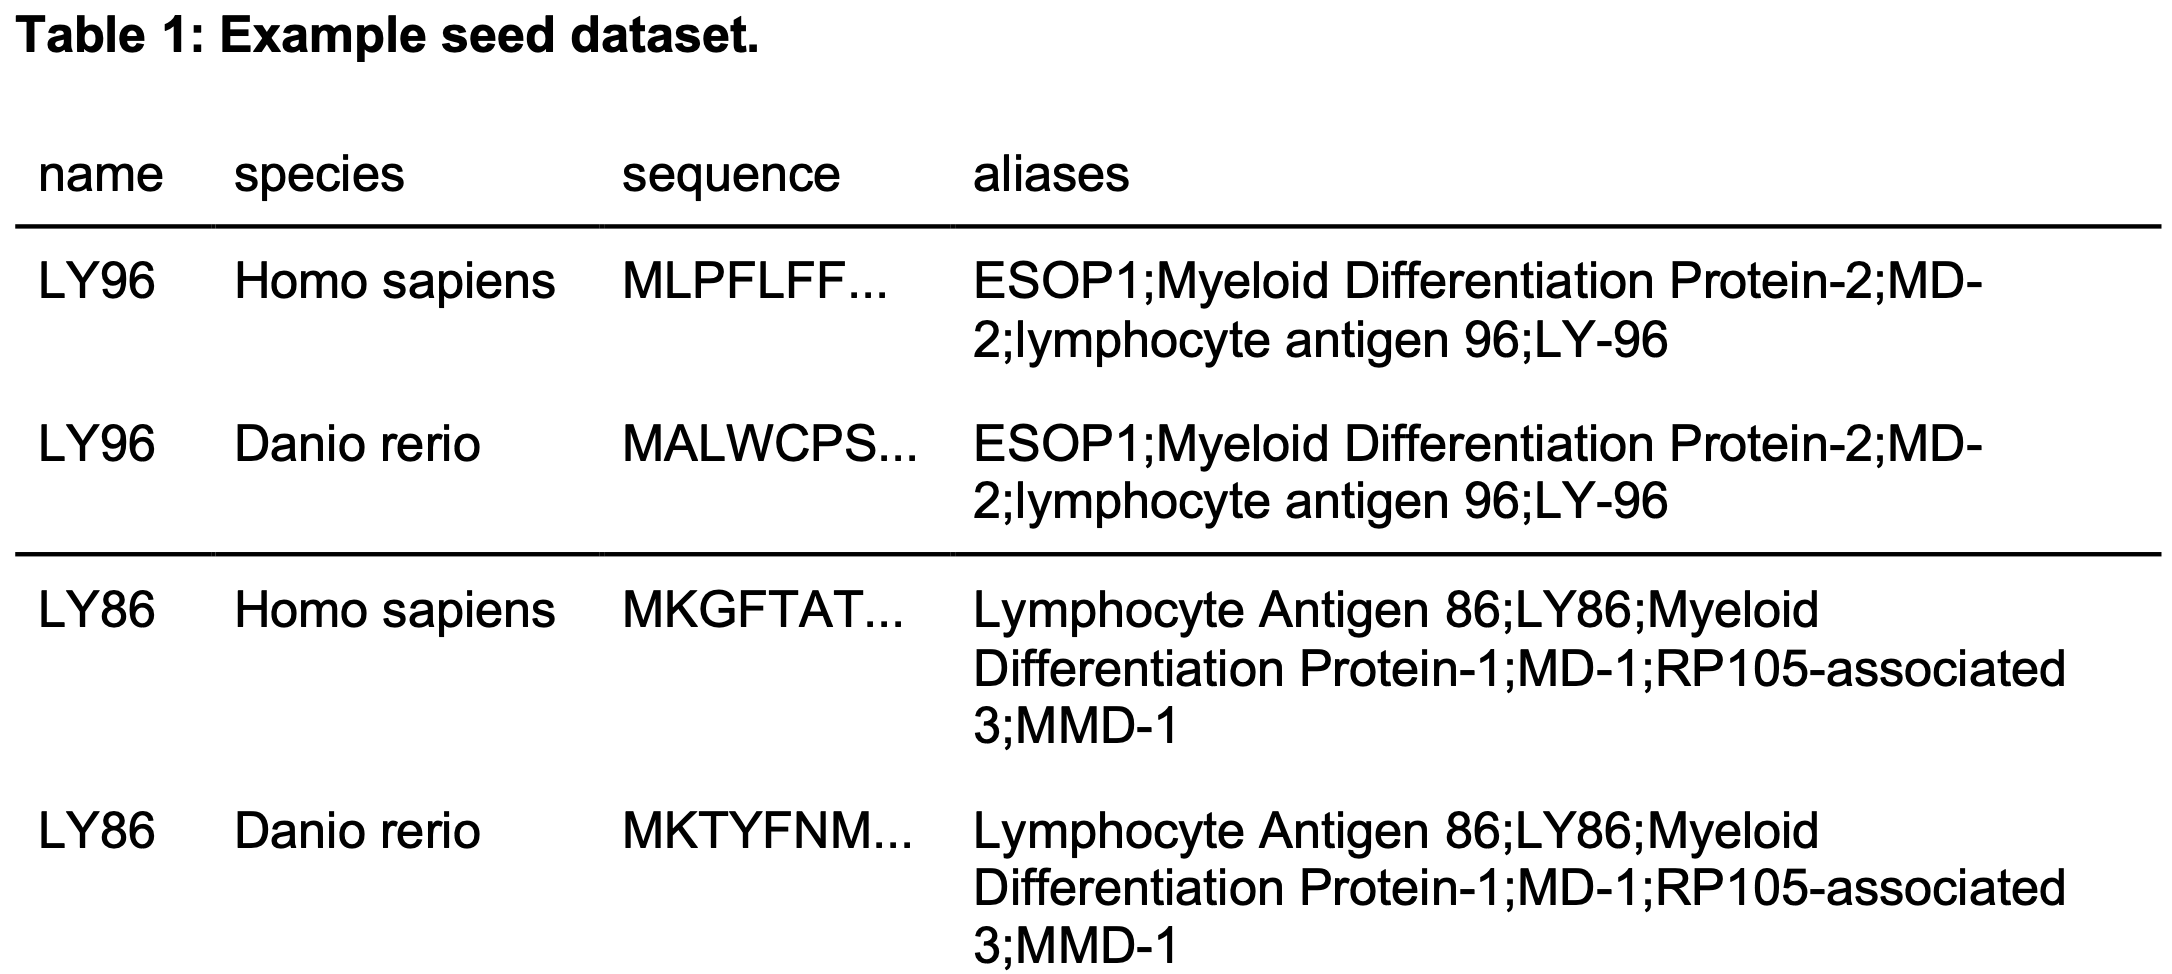
 


### To prepare the table:
1. **Choose the proteins of interest for your ASR calculation.** In our example, we included two paralogs: LY86 and LY96. The choice of proteins sets the scope of the evolutionary study. To study the deepest ancestor of LY86, we want to include LY96 as the relevant outgroup. In our experience, you generally want ~1-5 paralogs for a robust ASR investigation. As you add more paralogs, you need more sequences to resolve the evolutionary tree, slowing the calculation and—eventually—making the problem computationally intractable.
2. **Determine the taxonomic distribution of the protein family.** LY86 and LY96 are found across bony vertebrates (humans and bony fishes, but not sharks). If you are unsure of the taxonomic distribution of your proteins of interest, we discuss BLAST strategies for asking this question in the online topiary documentation.
3. **Choose two or three key species with well-annotated genomes that span the whole taxonomic distribution of your proteins of interest.** For LY86 and LY96, we selected humans and zebrafish, covering the breadth of species over which these proteins are found. Choosing humans and chimps would be a poor choice, as this covers only primates; even choosing humans and chickens would be non-optimal, as this covers only amniotes.
4. **Add sequences for each protein from your key species to the table.** These sequences are the basis for automatic dataset construction; they should therefore be high quality sequences: canonical rather than isoform, not hypothetical, not partial, etc. Our usual source for these seed sequences is Uniprot, but these can come from any source.
5. **Compile a list of aliases for each protein.** The same protein can have different names across different databases and species. Even in the same genome, gene nomenclature can be inconsistent. By using a human-curated list of aliases, topiary is more effective at identifying sequences that truly correspond to the paralogs of interest. Aliases can be found in many online databases. (A list of databases is given in the online documentation).

### Load your seed dataset

In [ ]:
#@title Load seed dataset

#@markdown Before running this cell, specify either: 
#@markdown + A file containing a seed dataset in your working
#@markdown directory (your google drive specified above). The default input 
#@markdown file is an example LY86/LY96 seed dataset.
#@markdown + Select `upload_file` to upload a file directly from your computer. 

seed_dataset = "https://raw.githubusercontent.com/harmslab/topiary-examples/main/data/ly86-ly96.csv" #@param {type:"string"}
upload_file = False #@param {type:"boolean"}

if issubclass(type(seed_dataset),str):
    seed_dataset = seed_dataset.strip()

if seed_dataset != "" and upload_file:
    err = "Please give a seed_dataset OR select upload file\n"
    raise ValueError(err)
  
if seed_dataset == "" and not upload_file:
    err = "Please either give a seed_dataset or select upload file\n"
    raise ValueError(err)

if upload_file:

    try:
        from google.colab import files
        uploaded_files = files.upload()
        keys = list(uploaded_files.keys())
        seed_dataset = keys[0] #uploaded_files[keys[0]]
    except ImportError:
        pass

seed_data = seed_dataset
    
try:
    seed_df = pd.read_csv(seed_dataset)
except:
    try:
        seed_df = pd.read_excel(seed_dataset)
    except:
        err = f"Could not read {seed_dataset}. This should be a csv or xlsx file\n"
        raise ValueError(err)

seed_df 

# Seed-to-alignment
### Argument definitions and default parameters
----------
**seed_df** : *pandas.DataFrame or str*
<br> Dataframe with at least four columns: name, species, sequence, and aliases. See documentation on seed dataframes for details.

**out_dir** : *str, optional*
<br> An output directory to save results into. If not specified, create an output directory with the format `seed_to_alignment_{randomletters}`.

**seqs_per_column** : *float, default=1*
<br> Aim to have this number of sequences per column in the key species sequences. (For example, if the key sequence is 100 amino acids long, seqs_per_column=1 would aim for 100 sequences; 2 would aim for 200 sequences).

**max_seq_number** : *int, default=500*
<br> Maximum number of sequences to get, regardless of `seqs_per_column` and lengths of sequences in seed dataframe.

**redundancy_cutoff** : *float, default=0.90*
<br> Merge sequences from closely related species with sequence identity above cutoff.

**worst_align_drop_fx** : *float, default=0.1*
<br> After alignment, drop approximately this fraction of the sequences, selecting those that have long insertions and are missing chunks of sequences.

**sparse_column_cutoff** : *float, default=0.80*
<br> When checking alignment quality, a column is sparse if it has gaps in more than `sparse_column_cutoff` sequences.

**align_trim** : *tuple, default=(0.05,0.95)*
<br> When checking alignment quality, do not score the first and last parts of the alignment. These are often non-coding and highly variable. Interpreted like a slice, but with percentages. `(0.0,1.0)` would use 100% of the alignment to score quality; `(0.05,0.98)` would only score quality of the alignment after the first 0.05 up until the last 0.02 from the end.
<br>
<br>

**ncbi_blast_db** : *str, optional*
<br> NCBI BLAST database to use. (If `ncbi_blast_db`, `local_blast_db` and `blast_xml` are all None, `ncbi_blast_db` is automatically set to "nr").

**local_blast_db** : *str, optional*
<br> Local BLAST database to use.

**blast_xml** : *str or list, optional*
<br> Previously generated BLAST .xml files to load. This argument can be:
+ single .xml file (str)
+ list of .xml files (list of str)
+ directory (str). Topiary will load all .xml files in the directory.
<br>

**move_mrca_up_by** : *int, default=2*
<br> When inferring the phylogenetic context from the seed dataframe, get the most recent common ancestor of the seed species, then find the taxonomic rank `move_mrca_up_by` levels above that ancestor. For example, if the key species all come from marsupials (Theria) and `move_mrca_up_by == 2`, the context will be Amniota (Theria -> Mammalia -> Amniota). Note: if all species in the dataset are bacteria or archaea, this argument is ignored and the context will be set to `Bacteria` or `Archaea`. 

**local_recip_blast_db** : *str, optional*
<br> Local BLAST database to use for reciprocal BLAST. If None, construct a reciprocal BLAST database by downloading the proteomes of the key species from the NCBI. 

**min_call_prob** : *float, default=0.95*
<br> Hits from all paralogs that yield a regular expression match to one of the aliases from the seed dataframe are weighted by their relative BLAST bit scores. Each paralog is assigned a relative probability. This cutoff is the minimum probability the best paralog match must have to result in a paralog call. Value should be between 0 and 1 (not inclusive), where increasing min_call_prob increases the stringency.

**partition_temp** : *float, default=1*
<br> When calculating posterior probability of the reciprocal BLAST paralog call, use this for weighting: `2^(bit_score/partition_temp)`. `partition_temp` should be a float > 0. A higher value corresponds to a higher stringency. (The bit score difference between the best hit and the bit scores of other hits would have to be higher to be significant). This is a minimum value. It may be adjusted automatically to avoid numerical problems in the calculation.
<br>
<br>

**hitlist_size** : *int, default=5000*
<br> Download only the top `hitlist_size` hits in initial BLAST.

**e_value_cutoff** : *float, default=0.001*
<br> Only take hits with e-value better than `e_value_cutoff` in initial BLAST.

**gapcost** : *tuple, default=(11,1)* 
<br> BLAST gapcosts (length 2 tuple of ints) in initial BLAST. The raw score of an alignment is the sum of the scores for aligning pairs of residues and the scores for gaps. Gapped BLAST and PSI-BLAST use "affine gap costs" which charge the score -a for the existence of a gap, and the score -b for each residue in the gap. Thus a gap of k residues receives a total score of -(a+bk); specifically, a gap of length 1 receives the score -(a+b) (http://pga2.mgh.harvard.edu:8080/rtpcr/blast/docs/matrix_info.html). The default (11,1) would provide scores -(11+k) for each gap with k residues.

**num_ncbi_blast_threads** : *int, default=1*
<br> Number of threads to use for NCBI BLAST. -1 means use all available. (Note that multithreading rarely speeds up remote BLAST).

**num_local_blast_threads** : *int, default=-1*
<br> Number of threads to use for local BLAST. -1 means all available.
<br>
<br>

**restart** : *bool, default=False*
<br> Restart job from where it stopped in output directory. Incompatible with overwrite. This argument requires specifying a value for `out_dir`.

**overwrite** : *bool, default=False*
<br> Overwrite `out_dir` if it already exists. Incompatible with restart.

**keep_recip_blast_xml** : *bool, default=False*
<br> Whether or not to keep raw BLAST .xml output.

**verbose** : *bool, default=False*
<br> Verbosity of output.
<br>
<br>
Returns
----------
**topiary_dataframe** : *pandas.DataFrame*
<br> Topiary dataframe with aligned, quality-controlled sequences.

----------

In [ ]:
#@title Run the seed-to-alignment script

#@markdown At this point, the seed dataset is ready to be passed to the topiary
#@markdown seed-to-alignment pipeline. This step uses BLAST to build a dataset
#@markdown of thousands of protein sequences, performs quality control, lowers 
#@markdown alignment redundancy in a taxonomically informed fashion, and then 
#@markdown generates an alignment of sequences. This generally takes less than 
#@markdown an hour on a modern laptop. The slowest step in this pipeline is 
#@markdown often the initial NCBI BLAST step. If your connection is unstable or
#@markdown the NCBI server proves too slow, topiary can BLAST against local
#@markdown databases or load previously saved BLAST XML results into this script
#@markdown -- as long as you have uploaded these files into your Colab content 
#@markdown folder. This script will generate and save a series of spreadsheets, 
#@markdown each capturing the state of the dataset at each step in the pipeline. 
#@markdown The final output consists of a single spreadsheet 
#@markdown (05_clean-aligned-dataframe.csv) and a single fasta file 
#@markdown (06_alignment.fasta) holding the alignment.
#@markdown 
#@markdown Please execute this cell by pressing the _Play_ button
#@markdown to run the full seed-to-alignment pipeline. The results can be 
#@markdown accessed in the seed-to-ali folder.
#@markdown 
#@markdown **If you need to re-run this cell, first re-run the "Initialize 
#@markdown environment" cell to reset your working directory.**
#@markdown 
#@markdown The user can manipulate several parameters listed here--argument 
#@markdown definitions and default parameters are described above.

out_dir="seed-to-ali" #@param {type:"string"}
seqs_per_column=1 #@param {type:"number"}
max_seq_number=500 #@param {type:"integer"}
redundancy_cutoff=0.90 #@param {type:"number"}
worst_align_drop_fx=0.1 #@param {type:"number"}
sparse_column_cutoff=0.80 #@param {type:"number"}
align_trim_first=0.05 #@param {type:"number"}
align_trim_last=0.95 #@param {type:"number"}
ncbi_blast_db=None #@param {type:"string"}
local_blast_db=None #@param {type:"string"}
blast_xml=None #@param {type:"string"}
move_mrca_up_by=2 #@param ["0", "1", "2", "3", "4"]
local_recip_blast_db=None #@param {type:"string"}
min_call_prob=0.95 #@param {type:"slider", min:0.01, max:0.99, step:0.01}
partition_temp=1 #@param {type:"number"}
hitlist_size=5000 #@param {type:"integer"}
e_value_cutoff=0.001 #@param {type:"number"}
gapcost_gap_exists=11 #@param {type:"integer"}
gapcost_per_residue=1 #@param {type:"integer"}
num_ncbi_blast_threads=1 #@param {type:"integer"}
num_local_blast_threads=-1 #@param {type:"integer"}
#restart=False #@param {type:"boolean"}
overwrite=False #@param {type:"boolean"}
keep_recip_blast_xml=False #@param {type:"boolean"}
verbose=False #@param {type:"boolean"}

df = topiary.seed_to_alignment(seed_df=seed_data,
                      out_dir=out_dir,
                      seqs_per_column=seqs_per_column,
                      max_seq_number=max_seq_number,
                      redundancy_cutoff=redundancy_cutoff,
                      worst_align_drop_fx=worst_align_drop_fx,
                      sparse_column_cutoff=sparse_column_cutoff,
                      align_trim=(align_trim_first,align_trim_last),
                      ncbi_blast_db=ncbi_blast_db,
                      local_blast_db=local_blast_db,
                      blast_xml=blast_xml,
                      move_mrca_up_by=move_mrca_up_by,
                      local_recip_blast_db=local_blast_db, 
                      min_call_prob=min_call_prob,
                      partition_temp=partition_temp,
                      hitlist_size=hitlist_size,
                      e_value_cutoff=e_value_cutoff,
                      gapcosts=(gapcost_gap_exists,gapcost_per_residue),
                      num_ncbi_blast_threads=num_ncbi_blast_threads,
                      num_local_blast_threads=num_local_blast_threads,
                      #restart=restart,
                      overwrite=overwrite,
                      keep_recip_blast_xml=keep_recip_blast_xml,
                      verbose=verbose)

topiary.write_dataframe(df,"alignment.csv")

## Inspect and edit alignment

Before reconstructing a phylogenetic tree and ancestors, we strongly recommend inspecting and possibly editing the alignment. 

To get started, download the 06_alignment.fasta file onto your computer. To do this, click on the folder icon on the Colab menu on the left side of the window. Navigate into the seed-to-ali folder (or the name you gave your output directory in the previous step), hover over "06_alignment.fasta", click on the three dots to the right and choose "Download."

There are a variety of pieces of software for visualizing alignments, including AliView (Larsson A, 2014), JALView (Waterhouse AM, 2009), and MEGA (Tamura K, 2021). We generally use AliView because of its balance of utility and simplicity.
There are differing views on whether to manually edit an alignment (Catanach TA, 2019; Morrison DA, 2006); the topiary package allows a user to manually edit their alignment but does not require it. We generally recommend making a few adjustments to alignments. Importantly, if we edit an alignment, we publish the alignment as supplemental material in the resulting manuscript so others can reproduce our work. We use the four “moves” listed below (see the [documentation](https://topiary-asr.readthedocs.io/en/latest/) for detailed instructions and examples).

1. Trim variable-length N- and C-terminal regions from the alignment. A huge number of sparse and variable columns will slow evolutionary analyses and will generally not provide enough signal to be reconstructed with confidence.
2. Delete sequences with long, unique insertions or deletions (indels). Indels can lead to alignment ambiguity around flanking regions. Further, they provide no information for most ancestors, most of whom do not have the indel, while increasing the computational cost of the phylogenetic analysis. Note, we do not make internal edits to sequences (say, by deleting a long lineage-specific insertion) as this becomes difficult to track or justify upon future realignment steps.
3. Delete lineage-specific duplicates, selecting the sequence with the greatest sequence coverage. The pipeline generally does a good job of deleting sequences in this class; however, if such sequences slip through, we delete them from the alignment.
Because trying to align long, unique, and variable sequences can affect the alignment of other sequences, we generally use Muscle5 to re-align the full MSA after we perform steps 1-3. This can be done directly from AliView. (We will often iterate through steps 1-3 and full alignment several times).
4. Finally, after we are satisfied that we have sequences of reasonable length and composition, we carefully inspect the alignment and may correct “obvious” local misalignments. In our view, these edits makes the alignment a more accurate description of sequence homology than otherwise; however, we recognize that this is subjective and difficult to quantify. As noted above, we publish our alignment with our final ancestors to allow others to assess our judgement and promote reproducibility.





Once the alignment is finalized, it can be read back into the topiary spreadsheet with the command line script *topiary-read-fasta-into*.

In [ ]:
#@title XX Load the topiary spreadsheet

#@markdown If you closed this notebook to edit your alignment or are not running
#@markdown the notebook in order, you must designate the topiary spreadsheet 
#@markdown (alignment.csv output from the previous cell) that corresponds to the 
#@markdown edited alignment.fasta file you are about to upload.
#@markdown Run this cell to load in your alignment.csv file. 
#@markdown 
#@markdown *If you are running this notebook straight through, skip this cell.*

alignment_before_edits = "alignment.csv" #@param {type: "string"}
upload_file = False #@param {type: "boolean"}

if issubclass(type(alignment_before_edits),str):
    alignment_before_edits = alignment_before_edits.strip()

if alignment_before_edits != "" and upload_file:
    err = "Please give an alignment OR select upload file\n"
    raise ValueError(err)
  
if alignment_before_edits == "" and not upload_file:
    err = "Please either give an alignment or select upload file\n"
    raise ValueError(err)

if upload_file:

    try:
        from google.colab import files
        uploaded_files = files.upload()
        keys = list(uploaded_files.keys())
        alignment_before_edits = keys[0] #uploaded_files[keys[0]]
    except ImportError:
        pass
    
try:
    df = pd.read_csv(alignment_before_edits)

except:
    err = f"Could not read {alignment_before_edits}. This should be a .fasta file\n"
    raise ValueError(err)

In [ ]:
#@title XX Read the alignment back into the topiary spreadsheet

#@markdown Before running this cell, specify either: 
#@markdown + A file containing an alignment (.fasta) in your working
#@markdown directory (seed-to-ali). 
#@markdown + Select `upload_file` to upload a file directly from your computer. 

uploaded_fasta_file = "" #@param {type: "string"}
upload_file = False #@param {type:"boolean"}

if issubclass(type(uploaded_fasta_file),str):
    uploaded_fasta_file = uploaded_fasta_file.strip()

if uploaded_fasta_file != "" and upload_file:
    err = "Please give an alignment OR select upload file\n"
    raise ValueError(err)
  
if uploaded_fasta_file == "" and not upload_file:
    err = "Please either give an alignment or select upload file\n"
    raise ValueError(err)

if upload_file:

    try:
        from google.colab import files
        uploaded_files = files.upload()
        keys = list(uploaded_files.keys())
        uploaded_fasta_file = keys[0] #uploaded_files[keys[0]]
    except ImportError:
        pass
    
try:
    alignment_df = topiary.read_fasta_into(df,uploaded_fasta_file)

except:
    err = f"Could not read {uploaded_fasta_file}. This should be a .fasta file\n"
    raise ValueError(err)

alignment_df